In [149]:
import pandas as pd
from extract_data import extract_data
import numpy as np
import umap
import sklearn
from scipy.optimize import linear_sum_assignment

In [83]:
df = pd.read_csv('num_data.csv')

In [84]:
for i in df.columns:
    if 'generalelection' in i:
        df = df.drop(i,1)

In [85]:
data_array = np.array(df)

In [86]:
general = extract_data("data","data",1)

In [87]:
for i in df.columns:
    if 'generalelection' in i:
        df = df.drop(i,1)

In [88]:
df['generalElectionVote'] = general['generalElectionVote']
df['generalElectionVote']

0                 Plaid Cymru
1                Conservative
2            Liberal Democrat
3                 Plaid Cymru
4                      Labour
                 ...         
34361                   Other
34362            Conservative
34363    I would/did not vote
34364            Conservative
34365            Conservative
Name: generalElectionVote, Length: 34366, dtype: category
Categories (12, object): ['An independent candidate', 'Brexit Party', 'Conservative', 'Don't know', ..., 'Other', 'Plaid Cymru', 'Scottish National Party (SNP)', 'United Kingdom Independence Party (UKIP)']

In [89]:
data = df
#removing don't know's and no votes from the labels, label choice is who people voted in the general election
data['generalElectionVote'] = data['generalElectionVote'].fillna("Don't know") 

list_to_remove = []
for i in range(data.shape[0]):
    if data.loc[i,'generalElectionVote'] == "Don't know":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "No - none":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Plaid Cymru":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Scottish National Party (SNP)":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==    'I would/did not vote':
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==  'Other':
        list_to_remove.append(i)
        
        
    
data = data.drop(list_to_remove,0)
data = data.reset_index(drop=True)


In [90]:
labels = pd.DataFrame({'generalElectionVote':data['generalElectionVote']})
labels['Vote'] = labels['generalElectionVote'].cat.remove_unused_categories()

In [91]:
mapping = {item:i for i, item in enumerate(labels["Vote"].unique())}
labels["EnumLabl"] = labels["Vote"].apply(lambda x: mapping[x])

In [92]:

labels_array = np.array(labels['EnumLabl'],dtype=np.float64)

In [93]:
data_array = np.delete(data_array,list_to_remove,0)
data_array = np.delete(data_array,0,1)

In [94]:
data_array = np.delete(data_array,-1,1)

In [109]:
%%time
embedding = umap.UMAP(n_neighbors=15,n_components=3).fit_transform(data_array,y=labels_array)

Wall time: 30.5 s


In [96]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Full Data set Embedded via UMAP using Labels')

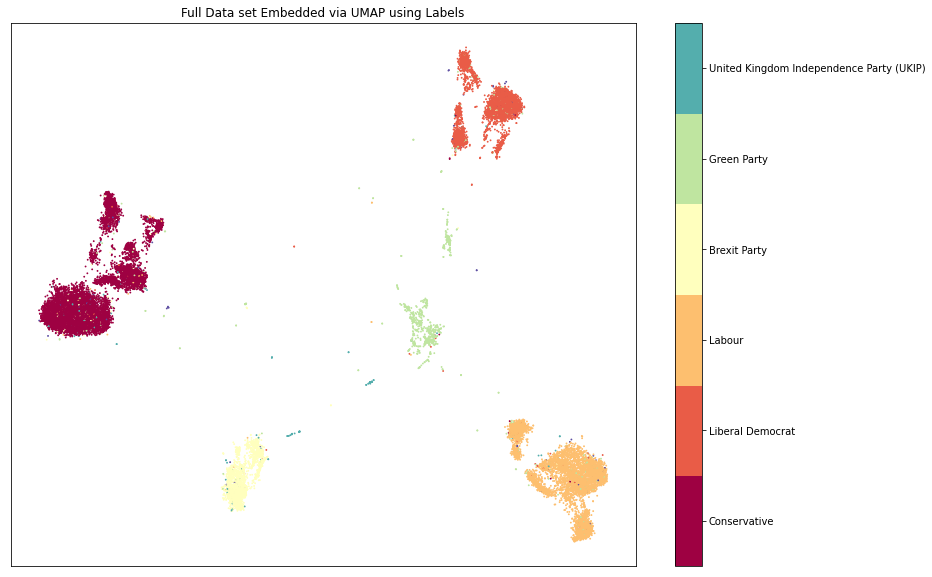

In [111]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,0],embedding[:,1], s=0.7, c=labels_array, cmap='Spectral', alpha=1.0,)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(labels["Vote"].unique())
plt.title('Full Data set Embedded via UMAP using Labels')

In [98]:
from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters, random_state=0).fit(embedding)

predictions = kmeans.predict(embedding)


In [99]:
from purity_check import purity_check

In [100]:
mean_purity = purity_check(kmeans.labels_,labels,10)
mean_purity

0.9716904687574232

In [104]:
def f1_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [112]:
def kmeans_distance(cluster,data_compare,n_clusters):
    cost_matrix = np.zeros([data_compare.shape[0],n_clusters])
    for i in range(data_compare.shape[0]):
        point_costs = []
        for c in range(n_clusters):
            diss = np.linalg.norm(data_compare[i,:]-cluster[c,:])
            cost_matrix[i,c]=diss
    return cost_matrix

In [143]:
#Elbow method
cluster_numbers.append(n_clusters)
sum_of_squared_distances = []
for i in range(6,20):
    cluster_numbers.append(i)
    kmeans = KMeans(i, random_state=0)
    kmeans.fit_predict(embedding)
    sum_of_squared_distances.append(kmeans.inertia_)
   
    

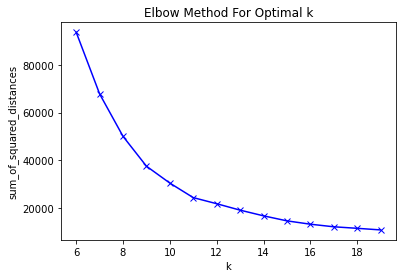

In [144]:
plt.plot(cluster_numbers, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
n_clusters = 11
#from elbow plot

In [147]:

kmeans = KMeans(n_clusters, random_state=0)
kmeans.fit_predict(embedding)
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
optimal_assignments = linear_sum_assignment(kmeans_cost)
cluster_assignments_names, cluster_assignments_number = f1_cluster_assignments_lists(optimal_assignments)
cluster_assignments = pd.DataFrame({'Party Vote':data['generalElectionVote']})
cluster_assignments['FirstAssignment'] = kmeans.labels_
for x in range(len(cluster_assignments_number)):
    cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].replace(int(cluster_assignments_number[x]),cluster_assignments_names[x])
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].astype('category')
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].cat.remove_unused_categories()
cluster_assignments['Party Vote'] = cluster_assignments['Party Vote'].cat.remove_unused_categories()
sum_of_squared_distances.append(kmeans.inertia_)
y_true = np.transpose(np.array(cluster_assignments['Party Vote']))
y_pred = np.transpose(np.array(cluster_assignments['FirstAssignment']))
f1 = sklearn.metrics.f1_score(y_pred,y_true,average='micro')
mean_purity = purity_check(kmeans.labels_,labels,n_clusters)

print('F1 score is:',f1)
print('purity is:', mean_purity)

F1 score is: 0.9657329240214889
purity is: 0.9570269315243035


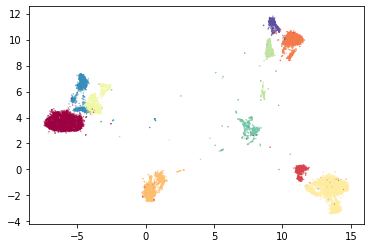

In [148]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [154]:
def optimal_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        name_count = 0 
        for x in range(len(optimal_cluster_assignments_names)):
                if name in optimal_cluster_assignments_names[x]:
                    name_count += 1
        if name_count != 0:
            name = name + str(name_count+1)
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [155]:
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
first_optimal_assignments = linear_sum_assignment(kmeans_cost)
first_cluster_assignments_names, first_cluster_assignments_number = optimal_cluster_assignments_lists(first_optimal_assignments)

In [156]:
print(first_cluster_assignments_number)
print(first_cluster_assignments_names)

[5, 4, 1, 9, 6, 8, 2, 3, 0, 7]
['Green Party', 'Conservative', 'Labour', 'Liberal Democrat', 'Liberal Democrat2', 'Conservative2', 'Liberal Democrat3', 'Brexit Party', 'Conservative3', 'Labour2']


In [ ]:
sklearn.preprocessing.normalize(kmeans_cost)

array([[0.0049139 , 0.41369521, 0.38901392, ..., 0.31346655, 0.07980265,
        0.39214968],
       [0.45700598, 0.29468258, 0.01050257, ..., 0.19663322, 0.42151995,
        0.09430791],
       [0.46082484, 0.09352165, 0.29772472, ..., 0.14464787, 0.4563718 ,
        0.31053944],
       ...,
       [0.16476089, 0.41118285, 0.40494772, ..., 0.31643308, 0.08868819,
        0.37518898],
       [0.15653022, 0.42550403, 0.38297138, ..., 0.30610051, 0.07457448,
        0.36129993],
       [0.01318411, 0.4158817 , 0.38590082, ..., 0.31653513, 0.07491839,
        0.38841417]])